# Naive Bayes

In previous lectures, we have seen **discriminative models** (like Logistic Regression). These models have one goal: learn the *decision boundary* between classes. They directly model the conditional probability $P(Y=k | X=\mathbf{x})$.

Recall that in this stage $Y$ is discrete and finite (our classes), while $X$ can be either continuous or discrete, scalar or multidimensional.

In this lecture, we will learn about a completely different family of classifiers: **generative models**, and in particular, we will see the **Naive Bayes** model.

Generative models do not explicitly model the decision boundary. Instead, their goal is to **learn the "story" or "profile" of each class independently**. They aim to build a full probabilistic model of what each class *looks like*.

Technically, this means they model the **joint probability distribution** $P(X,Y)$. Recalling that $P(X,Y)=P(X|Y)P(X)$, they do this by modeling two separate pieces:
1.  **The Likelihood $P(X=\mathbf{x} | Y=k)$:** "What does a typical $X$ look like *for this class*?"
2.  **The Prior $P(Y=k)$:** "How common is *this class* in general?"

Once the model has learned these two things, it can be used for classification.

## The Core Principle: Maximum A Posteriori (MAP)

Generative classifiers are built on the **Maximum A Posteriori (MAP)** principle. We want to find the class $k$ that is *most probable* after we observe the data $\mathbf{x}$.

$$h(\mathbf{x}) = \arg \max_{k} P(Y=k | X=\mathbf{x})$$

Using Bayes' theorem, we can "flip" this equation to use the *generative* pieces we've learned:

$$h(\mathbf{x}) = \arg \max_{k} \frac{P(X=\mathbf{x} | Y=k) P(Y=k)}{P(X=\mathbf{x})}$$

We note that, if we are not interested in computing the actual probabilities $P(Y=k|\mathbf{x})$, but we only want to assign $\mathbf{x}$ to the most likely class, we can drop the evidence $P(X=\mathbf{x})$, which is independent of class $k$. Indeed we note that:

$$P( Y=k | \mathbf{x} ) \propto P( X | Y=k )P(Y=k)$$

Which leads to the final MAP classification rule:

$$h\left( \mathbf{x} \right) = \arg \max_{k} \underbrace{P( X | Y=k )}_{\text{Likelihood}} \underbrace{P(Y=k)}_{\text{Prior}}$$

This approach is known as Maximum A Posteriori (MAP) classification as we aim to maximize the posterior probability.

In order to implement this principle, we need to compute the following two quantities:

-   The likelihood $P(X|Y)$;
-   The prior $P(Y)$;

We will now see how to compute each of these quantities.

### The Prior $P(Y)$

$P(Y)$: this is the **prior probability of a given class**. If observing
a class $Y=k$ is not very common, then $P(Y=k)$ will be small. We can use
different approaches to estimate $P(Y=k)$:

-   We can estimate $P(Y=k)$ by **considering the number of examples in
    the dataset**. For instance, if our dataset contains $800$ non-spam
    e-mails and $200$ spam e-mails and we set `Class 0 = Spam` and `Class 1 = Non Spam`,
     we can assume that $P(Y=0) = 0.2$ and $P(Y=1) = 0.8$.

-   Alternatively, we could ***study* what is the proportion of examples
    in each class in the real world**. In the case of spam detection, we
    could ask a large sample of people how many e-mails they receive in
    average and how many spam e-mails they receive. These numbers can be
    used to define the prior probability.

-   Another common choice, when we don't have enough information on the
    phenomenon is to **assume that all classes are equally probable**,
    in which case $P(Y=k) = \frac{1}{m}$*,* where $m$ is the number of
    classes.

There are many ways to define the prior probability. However, it should
be considered that this quantity should be interpreted in Bayesian
terms. This means that, by specifying a prior probability, we are
introducing our **degree of belief** on what classes are more or less
likely in the system.

### The Likelihood $P(X|Y)$

While estimating the prior is easy and estimating the evidence is not necessary for classification purposes (it would be indeed necessary if we were to compute probabilities), computing the likelihood term is less straightforward.

If we have $M$ different classes, a general approach to estimate the likelihood consists in group all observations belonging to a given class $Y=k$ (let's call $X_{k}$ the random variable of the examples
belonging to this group) and estimate the probability $P\left( X_{k} \right)$.

If we repeat this process for every possible value of $C$, we have
concretely estimated $P(X|Y=k)$ as:

$$P\left( X = x \middle| Y = k \right) = P(X_{k})$$

To estimate $P(X_{k})$ we will generally need to make a few assumptions. Depending on such assumptions, we obtain different generative models.

## The "Likelihood" Problem: From Ideal to Practical

The MAP rule is simple: $h(\mathbf{x}) = \arg \max_{k} P(X=\mathbf{x} | Y=k) P(Y=k)$.

The prior $P(Y=k)$ is easy to estimate (we just count). The *entire* challenge of generative modeling lies in estimating the **Likelihood, $P(X=\mathbf{x} | Y=k)$**.

How we do this depends on our features, and this is where we run into the **Curse of Dimensionality**.

### The "Ideal" Model for Discrete Data (and its Limitations)

If our features are discrete (e.g., `Offer=Yes`, `Free=No`), we could try to model $P(X|Y)$ by building a giant contingency table for every single combination of features.

* **The Problem:** If we have 10,000 words (features) in our vocabulary, we would need to estimate the probability for $2^{10,000}$ possible combinations. This is computationally and statistically impossible.

### The "Ideal" Model for Continuous Data: QDA

If our features are continuous (like the Iris dataset), we can't build a table. The "ideal" approach is to model $P(X=\mathbf{x} | Y=k)$ as a **Multivariate Gaussian (Normal) Distribution**, $N(\mathbf{\mu}_k, \mathbf{\Sigma}_k)$.

This is **Quadratic Discriminant Analysis (QDA)**. It's the most flexible Gaussian model.
* **Assumption:** Each class $k$ has its *own* mean vector $\mathbf{\mu}_k$ and its *own, full* covariance matrix $\mathbf{\Sigma}_k$.
* **The "Nightmare":** This is computationally a nightmare. To estimate a full covariance matrix $\mathbf{\Sigma}_k$ for $d$ features, we must estimate $\sim \frac{d^2}{2}$ parameters. For 100 features, that's $\approx 5,000$ parameters, *per class*. This requires massive amounts of data and overfits easily.
* **The Result:** A powerful, *curved (quadratic)* decision boundary.

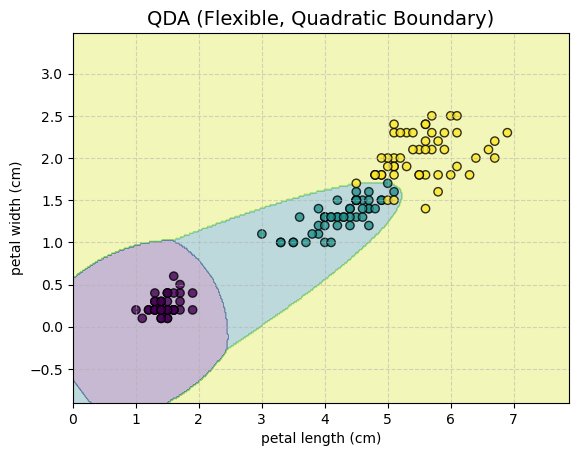

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from scipy.stats import multivariate_normal

# --- 1. Load and Prepare the Iris Data ---
iris = load_iris()
X = iris.data[:, [2, 3]] # Petal length and width
y = iris.target
target_names = iris.target_names
feature_names = iris.feature_names[2:]

# --- 2. Fit Both Models ---
# Fit QDA
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X, y)

# Fit LDA
lda = LinearDiscriminantAnalysis(store_covariance=True)
lda.fit(X, y)

# --- 3. Create a meshgrid to plot boundaries ---
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

# --- THIS IS THE CORRECTED LINE ---
# I replaced the invalid space character ' ' with a normal space
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
# -----------------------------------

# --- 4. Get predictions from both models ---
Z_qda = qda.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
Z_lda = lda.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# --- 5. Plot Side-by-Side ---

plt.contourf(xx, yy, Z_qda, alpha=0.3, cmap='viridis')
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8, edgecolor='k', cmap='viridis')
plt.title('QDA (Flexible, Quadratic Boundary)', fontsize=14)
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

### The First Simplification: Linear Discriminant Analysis (LDA)

The "nightmare" of QDA leads to our first compromise: **Linear Discriminant Analysis (LDA)**.

* **Assumption:** We simplify the problem by assuming all classes *share* the **same covariance matrix** ($\mathbf{\Sigma}_k = \mathbf{\Sigma}$ for all $k$).
* **The Benefit:** This is much more stable. We only have to estimate *one* full $\mathbf{\Sigma}$ matrix, not $k$ of them.
* **The "Nightmare" (Still):** We *still* have to estimate one full $\frac{d^2}{2}$ matrix. For text data with $d=10,000$, this is still impossible.
* **The Result:** This assumption forces the math to simplify, and the decision boundary is always *linear*.

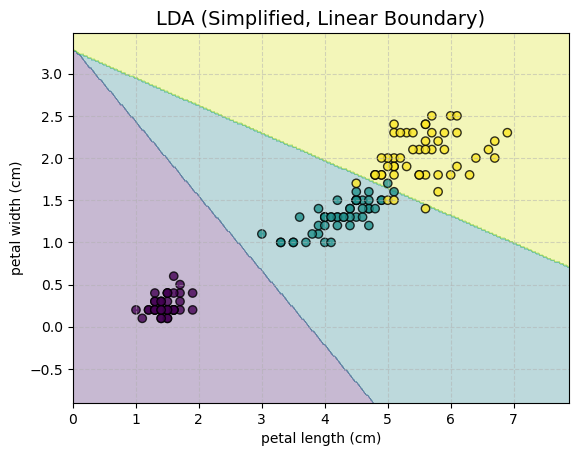

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from scipy.stats import multivariate_normal

# --- 1. Load and Prepare the Iris Data ---
iris = load_iris()
X = iris.data[:, [2, 3]] # Petal length and width
y = iris.target
target_names = iris.target_names
feature_names = iris.feature_names[2:]

# Fit LDA
lda = LinearDiscriminantAnalysis(store_covariance=True)
lda.fit(X, y)

# --- 3. Create a meshgrid to plot boundaries ---
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

Z_lda = lda.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Plot LDA
plt.contourf(xx, yy, Z_lda, alpha=0.3, cmap='viridis')
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8, edgecolor='k', cmap='viridis')
plt.title('LDA (Simplified, Linear Boundary)', fontsize=14)
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

## Naive Bayes: The Pragmatic Solution
While LDA makes it easier to fit the model to the data, it can still be very computationally demanding.

Indeed, for **very high-dimensional data** ($d=10,000$ features, like in text classification), estimating even *one* full covariance matrix $\hat{\mathbf{\Sigma}}$ can be computationally and statistically challenging. This is an aspect of the **Curse of Dimensionality**.

This leads us to our final and most extreme simplification: **Naive Bayes**.

### The "Naive" Assumption
Recall that our problem is estimating

$$P\left( X \middle| Y \right)$$

Considering a multidimensional $X=(X_1,X_2,\ldots,X_n)$, we may factorize the expression above as follows:

$$P\left( X \middle| Y \right) = P\left( X_{1},\ldots,X_{n} \middle| Y \right) = P\left( X_{1} \middle| Y \right)P\left( X_{2} \middle| X_{1},Y \right)P\left( X_{3} \middle| X_{2},X_{1},Y \right)\ldots P(X_{n}|X_{1},\ldots,X_{n - 1},Y)$$

However, this is not a very helpful factorization as the terms
$P(X_{i}|X_{1},\ldots,X_{i - 1},C)$ are conditioned also on other
features, which makes them not easy to model.

The Naive Bayes classifier makes one, very strong ("naive") assumption:

> It assumes that all features $X_i$ are **conditionally independent** given the class $Y=k$.

This can be written as follows:

$$X_{i}\bot X_{j}\ |\ Y,\ \forall i \neq j$$

> **Spam Classification Example**
> Let's assume a spam classification example and imagine that features $X_{i}$ and $X_{j}$ are related to the 
> number of appearance of specific words in the current email represented by $X$.
> If $X_{i}$ and $X_{j}$ are **word counts**, then we are saying that if I
> take all non-spam e-mails, then the number of occurrences of a given
> word **does not influence** the number of occurrences of **another
> word**. This is **obviously not true in general!** For instance, there
> can be legitimate e-mails of different topics. If the e-mail is about a
> vacation, the words 'trip', 'flight', 'luggage' will appear often.
> Instead, if the e-mail is about work, the words 'meeting', 'report',
> 'time', will appear more often. This means that, within the same
> category (non-spam e-mails), the number of occurrences of a word (e.g.,
> 'trip') may be related to the number of occurrences of another words
> (e.g., 'flight'), which breaks the assumption of **conditional
> independence**. This is why this assumption is called **naïve
> assumption**. With this in mind, it should be considered that, despite
> such naïve assumption, the Naïve Bayes Classifier works surprisingly
> well in many contexts.

We know that:

$$X\bot Y|Z \Leftrightarrow P\left( X,Y|Z \right) = P\left( X|Z \right)P\left( Y|Z \right)$$

Hence, we discover that, under the assumption of conditional
independence:

$$P\left( X_{1},\ldots,X_{n} \middle| Y \right) = P\left( X_{1} \middle| Y \right)P\left( X_{2} \middle| Y \right)\ldots P(X_{n}|Y)$$

So, we can re-write the MAP classification rule as:

$$f(\mathbf{x}) = \arg_{k}max\ P\left( \mathbf{x}_{1} \middle| Y=k \right)\left( \mathbf{x}_{2} \middle| Y=k \right)\ldots P\left( \mathbf{x}_{n} \middle| Y=k \right)P(Y=k)$$

### Flavors of Naive Bayes

The single $P(X_{1}|Y=k)$ terms are now easy to model, since $X_{1}$ is
mono-dimensional. In practice, depending on the considered problem, we
can model these terms in different ways. Two common approaches,
depending on the kind of data we have, are to use a **Gaussian distribution** or a
**Multinomial distribution**.

When we use Gaussian distributions to model the $P(X_{i}|Y)$ terms, the
classification method is called "**Gaussian Naïve Bayes**". Similarly, if we
consider a multinomial distribution, the classification method is called
"**Multinomial Naïve Bayes**".

### Gaussian Naïve Bayes

Let us consider again our sex classification example based on height and
weight. We will consider $X = \lbrack H,W\rbrack$, which are random
variables representing heights and weights of subjects. If we assume
that the data is approximately Gaussian, the probabilities $P(H|C)$ and
$P(W|C)$ can be modeled with univariate (1D) Gaussian distributions.
This is done by first obtaining four samples:

-   $H_{1}$: the heights of subjects when $C = 1$;

-   $W_{1}$: the weights of subjects when $C = 1;$

-   $H_{0}$: the heights of subjects when $C = 0$;

-   $W_{0}$: the weights of subjects when $C = 0.$

> We hence model each sample as a 1D Gaussian distribution by computing
> a mean and a variance value from each of these samples to obtain four
> Gaussian distributions:

-   $P\left( H = h \middle| C = 0 \right) = N(x;\mu_{1},\sigma_{1})$;

-   $P\left( W = w \middle| C = 0 \right) = N(x;\mu_{2},\sigma_{2})$;

-   $P\left( H = h \middle| C = 1 \right) = N(x;\mu_{3},\sigma_{3})$;

-   $P\left( W = w \middle| C = 1 \right) = N(x;\mu_{4},\sigma_{4})$;

After this, we can apply the classification rule:

-   The example $(h,w)$ is classified as class 1 if

$P\left( h \middle| C = 1 \right)P\left( w \middle| C = 1 \right)P(C = 1) > P\left( h \middle| C = 0 \right)P\left( w \middle| C = 0 \right)P(C = 0)$;

-   The example $(h,w)$ is classified as class 0 otherwise.

We can exemplify this process as follows:

![](../_static/lecture_specific/classification/map_weight3.png)

#### Gaussian Naive Bayes and QDA
Let's compare the decision boundaries of the three classifiers:

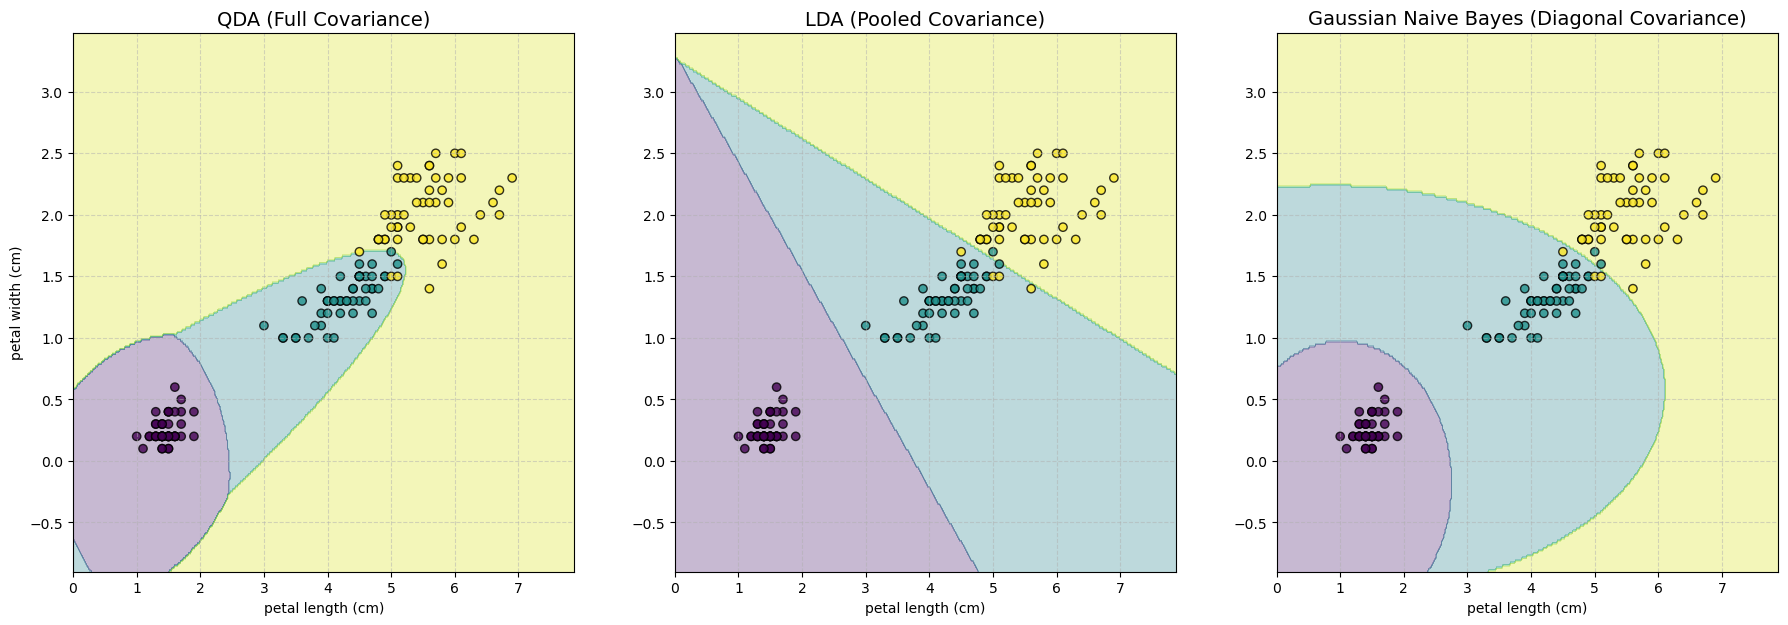

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from scipy.stats import multivariate_normal

# --- 1. Load and Prepare the Iris Data ---
iris = load_iris()
X = iris.data[:, [2, 3]] # Petal length and width
y = iris.target
target_names = iris.target_names
feature_names = iris.feature_names[2:]

# --- 2. Fit All Three Models ---
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X, y)

lda = LinearDiscriminantAnalysis(store_covariance=True)
lda.fit(X, y)

gnb = GaussianNB()
gnb.fit(X, y)

# --- 3. Create a meshgrid to plot boundaries ---
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# --- 4. Get predictions from all models ---
Z_qda = qda.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
Z_lda = lda.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
Z_gnb = gnb.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# --- 5. Plot Side-by-Side-by-Side ---
plt.figure(figsize=(22, 7))

# Plot QDA
plt.subplot(1, 3, 1)
plt.contourf(xx, yy, Z_qda, alpha=0.3, cmap='viridis')
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8, edgecolor='k', cmap='viridis')
plt.title('QDA (Full Covariance)', fontsize=14)
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.grid(True, linestyle='--', alpha=0.5)

# Plot LDA
plt.subplot(1, 3, 2)
plt.contourf(xx, yy, Z_lda, alpha=0.3, cmap='viridis')
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8, edgecolor='k', cmap='viridis')
plt.title('LDA (Pooled Covariance)', fontsize=14)
plt.xlabel(feature_names[0])
plt.grid(True, linestyle='--', alpha=0.5)

# Plot Gaussian Naive Bayes
plt.subplot(1, 3, 3)
plt.contourf(xx, yy, Z_gnb, alpha=0.3, cmap='viridis')
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8, edgecolor='k', cmap='viridis')
plt.title('Gaussian Naive Bayes (Diagonal Covariance)', fontsize=14)
plt.xlabel(feature_names[0])
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

This figure perfectly summarizes the three models:
* **QDA (Left):** Most flexible. It learns a separate, *rotated* ellipse (full $\mathbf{\Sigma}_k$) for each class. Its boundaries are quadratic.
* **LDA (Middle):** The compromise. It learns *one* pooled, *rotated* ellipse (full $\mathbf{\Sigma}$) and uses it for all classes. Its boundaries are linear.
* **GNB (Right):** Most simple. It learns a separate, *axis-aligned* ellipse (diagonal $\mathbf{\Sigma}_k$) for each class. Its boundaries are quadratic but can't capture any feature correlation (tilt).

### Multinomial Naïve Bayes

In the previous examples, we have considered cases in which the input
features are continuous. In these cases, indeed, it can make sense to
**estimate likelihoods using continuous probability distributions**
(PDF) such as the Gaussian distribution. When the input features are
discrete instead, it makes sense to **approximate them as probability
mass functions (PFM)**.

Let us consider for instance the case of **text classification**. If we
represent text using word counts (bag of words representation), the
input features will be **discrete**. In particular, given a vocabulary
$V$ of size $n$, the input features will be tuples of $n$ natural
numbers:

$$\mathbf{x} = (x_{1},x_{2},x_{3},\ldots,x_{n})$$

with $x_{i} \in N$ being the number of times the term $i$
appears in document $\mathbf{x}$.

Hence, the probability of a given document **x**, given its class (the
likelihood) can be modeled as

$$P(x_{1},\ldots,x_{n}|c)$$

If we assume the **naïve hypothesis**, then we are saying that, given
documents of a fixed class, the number of times that word $i$
appears in the text is independent of the number of times that word $j$
appears in the text.

If we imagine the process of writing a document as the one of picking
words from the vocabulary $V$, then, chosen a class
$C = c$, we can model the probability
$P(x_{1},\ldots,x_{n}|C = c)$ with a **multinomial distribution**.
Recall that we need to estimate a different multinomial distribution for
each possible value of $C$.

Remember that **the multinomial distribution models the probability of
obtaining exactly**
$\mathbf{(}\mathbf{n}_{\mathbf{1}}\mathbf{,\ldots,}\mathbf{n}_{\mathbf{k}}\mathbf{)}$
**occurrences with**
$\mathbf{n}\mathbf{=}\sum_{\mathbf{i}}^{}\mathbf{n}_{\mathbf{i}}$ **for
each of** $\mathbf{k}$ **possible outcomes in a sequence of**
$\mathbf{n}$ **independent experiments which follow categorical
distributions with probabilities**
$\mathbf{p}_{\mathbf{1}}\mathbf{,\ldots,}\mathbf{p}_{\mathbf{k}}$.

In our case, the individual "experiments" consist in the process of
generating a word. We can assume that this process follows a categorical
distribution with some words being more common than others. These
experiments are *independent* because of the naïve assumption.

To characterize our multinomial distribution, we need to fix/estimate
some parameters:

-   **Number of experiments**: the number of words in the document. This
    will be the sum of the features $\sum_{i}^{}x_{i}$.

-   **Number of possible outcomes**: the number of words in the
    vocabulary.

-   **Probability of each outcome**: the probability of generating a
    word, given the class. We will call this probability
    $p_{\text{ci}}$. The most common way to evaluate this term is by
    **counting the number of times that each word appears in all
    documents of a given class**.

Hence, we can solve text classification with MAP using the expression:

$$f\left( x_{1},\ \ldots,x_{n} \right) = \arg_{c}\text{max~}P\left( x_{1},x_{2},\ldots,c_{n} \middle| c \right)P\left( c \right)$$

Using the analytical form of the multinomial distribution:

$$f\left( x_{1},\ \ldots,x_{n} \right) = \arg_{c}\text{max~}P\left( c \right)\frac{(\sum_{i}^{}x_{i})!}{x_{1}!\ldots x_{n}!}p_{c1}^{x_{1}} \cdot p_{c2}^{x_{2}} \cdot \ldots \cdot p_{\text{cn}}^{x_{n}}$$

We can note that, similarly to the evidence $P(X)$, the term
$\frac{(\sum_{i}^{}x_{i})!}{x_{1}!\ldots x_{n}!}$ is independent from
$c$ and hence we can safely ignore it if our aim is not to compute
probability values:

$$f\left( x_{1},\ \ldots,x_{n} \right) = \arg_{c}\text{max~}P\left( c \right)p_{c1}^{x_{1}} \cdot p_{c2}^{x_{2}} \cdot \ldots \cdot p_{\text{cn}}^{x_{n}}$$

#### Estimating the Terms $p_{\text{ci}}$ and $P(c)$

We can model the terms $p_{\text{ci}}$ in a frequentist way as follows:

$$p_{\text{ci}} = \frac{\sum_{j}^{}{\left\lbrack y^{\left( j \right)} = c \right\rbrack x_{i}^{(j)}}}{\sum_{j}^{}{\sum_{k}^{}{\lbrack y^{(j)} = c\rbrack x_{k}^{(j)}}}}$$

Where $\left\lbrack \cdot \right\rbrack$ denotes the Iverson bracket,
which is defined as:

$$\left\lbrack x \right\rbrack = \left\{ \begin{matrix}
1\ \text{if}\ x\ \text{is}\ \text{true} \\
0\ \text{ot}h\text{erwise} \\
\end{matrix} \right.\ $$

Hence, in the expression above:

-   The numerator counts the number of times word $i$ appears in
    documents of class $c$;

-   The denominator counts all the words appearing in all documents of
    class $c$;

-   Hence, the expression is **the fraction of times word i appears
    among all words in documents of class c**;

In practice, since some words can have zero occurrences, we perform
'Laplacian smoothing' by adding a "1" to each term as follows:

$$p_{\text{ci}} = \frac{\sum_{j}^{}{\left\lbrack y^{\left( j \right)} = c \right\rbrack x_{i}^{(j)} + 1}}{\sum_{j}^{}{(\sum_{i}^{}{\left\lbrack y^{\left( j \right)} = c \right\rbrack x_{i}^{\left( j \right)} + 1)}}}$$

This allows to make sure that we do not divide by zero.

We can estimate the prior probability as:

$$p\left( c \right) = \frac{\sum_{j}^{}{\lbrack y^{\left( j \right)} = c\rbrack}}{N}$$

where $N$ is the total number of documents. Alternatively, we can assume
uniform priors and set:

$$P\left( c \right) = \frac{1}{M}$$

## Lab Bake-Off: The Right vs. The Wrong Tool for the Job

We've now seen a "family" of generative models (QDA, LDA, GNB) and know about discriminative models like KNN and Logistic Regression.

Let's run a "bake-off" to see what happens when we apply these models to a **high-dimensional text classification** problem (spam filtering). This will clearly demonstrate *why* `Multinomial Naive Bayes (MNB)` is a standard tool for this task, and why the other models we've learned are the **wrong tool for the job**.

#### The Competitors:
1.  **Text-Native Models:**
    * `MultinomialNB` (Generative, for counts)
    * `LogisticRegression` (Discriminative, works well with high-d text)
2.  **The "Wrong" Models:**
    * `KNeighborsClassifier` (Distance-based, suffers from Curse of Dimensionality)
    * `GaussianNB` (Generative, assumes features are Gaussian, not counts)
    * `LinearDiscriminantAnalysis` (Generative, needs a full covariance matrix)
    * `QuadraticDiscriminantAnalysis` (Generative, needs *multiple* full covariance matrices)

#### The Workflow:
1.  Load and clean the SMS Spam dataset.
2.  Create a single **Train/Test Split**.
3.  Build a `Pipeline` for each model. This is crucial:
    * `MNB` will use `CountVectorizer` (raw counts).
    * All other models will use `TfidfVectorizer` (normalized features).
    * The Gaussian models (GNB, LDA, QDA) *cannot* work with the default "sparse" matrix from a vectorizer, so we must build a custom "hack" to make them dense, which will highlight their inefficiency.
4.  Fit all models, capture their accuracy and training time, and catch the errors for the models that will (and should) fail.
5.  Compare all results in a final table and plot.

In [23]:
# --- 1. All Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# For data loading
import io
import zipfile
import urllib.request

# Sklearn Workflow Tools
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Sklearn Feature Engineering
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import TransformerMixin, BaseEstimator # For our custom transformer

# Sklearn Models (The Competitors)
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

#### Step 1: Load and Split the Data

First, we load the data from the UCI zip file, map the labels, and create our single, "locked-away" test set.

In [24]:
# 1. Load the dataset
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
try:
    with urllib.request.urlopen(url) as response:
        zip_data = response.read()

    # 2. Unzip the file in memory
    with zipfile.ZipFile(io.BytesIO(zip_data)) as z:
        # 3. Read the specific file from the zip archive into pandas
        with z.open('SMSSpamCollection') as f:
            df = pd.read_csv(f, 
                             sep='\t', 
                             header=None, 
                             names=['label', 'message'],
                             encoding='latin-1')

    # 4. Map labels to 0 (ham) and 1 (spam)
    df['label'] = df['label'].map({'ham': 0, 'spam': 1})

    print("--- Data Head ---")
    print(df.head())

    # 5. Define X and y
    X = df['message'] # The raw text
    y = df['label']   # The 0 or 1

    # 6. Create the Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    print(f"\nTraining samples: {len(X_train)}, Test samples: {len(X_test)}")

except Exception as e:
    print(f"Error loading or processing data: {e}")

--- Data Head ---
   label                                            message
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...

Training samples: 3900, Test samples: 1672


#### Step 2: Define Pipelines and Custom Transformer

We need a custom transformer to convert the sparse output of `TfidfVectorizer` into a dense `numpy` array, which GNB, LDA, and QDA require. This is intentionally inefficient and will highlight the "nightmare" of using these models on high-dimensional data.

In [25]:
# Custom Transformer to convert sparse matrix to dense
class DenseTransformer(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.toarray()

# --- 1. Define the models we want to test ---
models_to_test = {
    "Multinomial NB (Text-Native)": Pipeline([
        ('vectorizer', CountVectorizer(stop_words='english')),
        ('classifier', MultinomialNB())
    ]),
    
    "Logistic Regression (Discriminative)": Pipeline([
        ('vectorizer', TfidfVectorizer(stop_words='english')),
        ('classifier', LogisticRegression(random_state=42))
    ]),
    
    "K-Neighbors (Distance-Based)": Pipeline([
        ('vectorizer', TfidfVectorizer(stop_words='english')),
        ('classifier', KNeighborsClassifier(n_neighbors=5))
    ]),
    
    "Gaussian NB (Wrong Assumption)": Pipeline([
        ('vectorizer', TfidfVectorizer(stop_words='english')),
        ('to_dense', DenseTransformer()), # Must be dense for GNB
        ('classifier', GaussianNB())
    ]),
    
    "Linear Discriminant (LDA)": Pipeline([
        ('vectorizer', TfidfVectorizer(stop_words='english')),
        ('to_dense', DenseTransformer()), # Must be dense for LDA
        ('classifier', LinearDiscriminantAnalysis())
    ]),
    
    "Quadratic Discriminant (QDA)": Pipeline([
        ('vectorizer', TfidfVectorizer(stop_words='english')),
        ('to_dense', DenseTransformer()), # Must be dense for QDA
        ('classifier', QuadraticDiscriminantAnalysis())
    ])
}

# --- 2. Store the results ---
results = {}

#### Step 3: Run the Bake-Off

Now we loop, fit, and time each model. Watch what happens when we try to run the models that aren't designed for this kind of data.

In [26]:
for name, pipeline in models_to_test.items():
    print(f"--- Testing: {name} ---")
    start_time = time.time()
    
    try:
        # 1. Fit the pipeline
        pipeline.fit(X_train, y_train)
        
        # 2. Make predictions on the TEST set
        y_pred = pipeline.predict(X_test)
        
        # 3. Get the accuracy
        accuracy = accuracy_score(y_test, y_pred)
        
        # 4. Store results
        elapsed = time.time() - start_time
        results[name] = {'Test Accuracy': accuracy, 'Time (sec)': elapsed, 'Error': None}
        print(f"  Success! Accuracy: {accuracy*100:.2f}%, Time: {elapsed:.2f}s")

    except Exception as e:
        # Catch models that fail to train
        elapsed = time.time() - start_time
        results[name] = {'Test Accuracy': 0.0, 'Time (sec)': elapsed, 'Error': str(e)}
        print(f"  FAILED! Error: {e}")

--- Testing: Multinomial NB (Text-Native) ---
  Success! Accuracy: 98.74%, Time: 0.18s
--- Testing: Logistic Regression (Discriminative) ---
  Success! Accuracy: 96.23%, Time: 0.06s
--- Testing: K-Neighbors (Distance-Based) ---
  Success! Accuracy: 90.79%, Time: 0.17s
--- Testing: Gaussian NB (Wrong Assumption) ---
  Success! Accuracy: 87.50%, Time: 0.38s
--- Testing: Linear Discriminant (LDA) ---
  Success! Accuracy: 97.49%, Time: 45.11s
--- Testing: Quadratic Discriminant (QDA) ---


/opt/homebrew/anaconda3/lib/python3.13/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.13/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


  Success! Accuracy: 48.33%, Time: 25.36s


#### Step 4: Show the Final Results


--- FINAL BAKE-OFF RANKING (Spam Filter) ---
                                      Test Accuracy  Time (sec) Error
Multinomial NB (Text-Native)               0.987440    0.179027  None
Linear Discriminant (LDA)                  0.974880   45.111081  None
Logistic Regression (Discriminative)       0.962321    0.060569  None
K-Neighbors (Distance-Based)               0.907895    0.167808  None
Gaussian NB (Wrong Assumption)             0.875000    0.377862  None
Quadratic Discriminant (QDA)               0.483254   25.357229  None


/var/folders/cs/p62_d78d49n3ddj0xlfh1h7r0000gn/T/ipykernel_69318/2981998238.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plot_df = results_df.fillna(0)


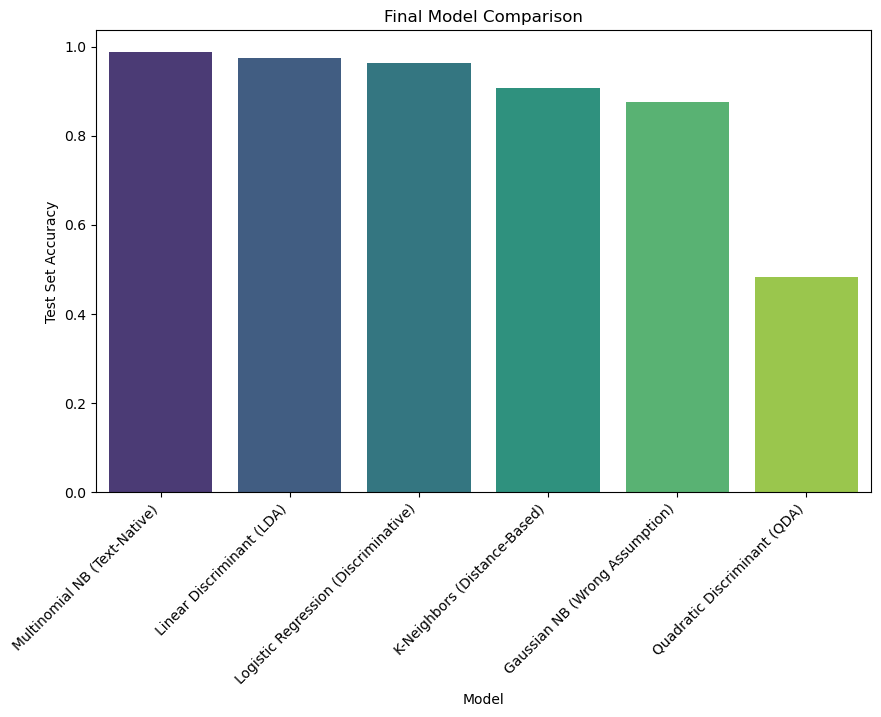

In [27]:
# Convert results to a pandas DataFrame for a "nice chart"
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df.sort_values(by='Test Accuracy', ascending=False)

print("\n--- FINAL BAKE-OFF RANKING (Spam Filter) ---")
# We'll also show Time and Error to tell the full story
pd.set_option('display.max_colwidth', 100) # Show more of the error message
print(results_df)

# Plot the accuracy
plt.figure(figsize=(10, 6))
# We create a new column for plotting, setting failed models' accuracy to 0
plot_df = results_df.fillna(0)
sns.barplot(x=plot_df.index, y=plot_df['Test Accuracy'], hue=plot_df.index, palette='viridis', legend=False)
plt.xlabel('Model')
plt.ylabel('Test Set Accuracy')
plt.title('Final Model Comparison')
plt.xticks(rotation=45, ha='right')
plt.show()

### Conclusion: The Right Tool for the Job

This bake-off tells a very clear story:

1.  **`Logistic Regression` and `MultinomialNB`** were the **winners**. They are designed to handle high-dimensional, sparse text data and performed excellently.

2.  **`GaussianNB`** performed poorly, but at least it ran. This is because our data is *counts* (mostly zeros), which does not follow a *Gaussian* (bell curve) distribution at all. This is a classic "Wrong Assumption" failure.

3.  **`KNeighborsClassifier`** was also very inaccurate. This is a perfect demonstration of the **Curse of Dimensionality**. With over 7,000 features, the "distance" between any two messages becomes meaningless, so the "nearest neighbor" is no longer a reliable predictor.

4.  **`LDA` and `QDA`** **took a long time to run and gave warnings**. 

**The final lesson is clear:** You must choose a model that matches the assumptions and dimensionality of your data. For high-dimensional, sparse count data like text, **Multinomial Naive Bayes** and **Logistic Regression** are the correct, industry-standard tools.

## References

-   Naïve Bayes Classifier: https://en.wikipedia.org/wiki/Naive_Bayes_classifier;
-   https://scikit-learn.org/stable/modules/lda_qda.html#lda-qda
-   Section 4.4 of \[1\]

\[1\] James, Gareth Gareth Michael. An introduction to statistical learning: with applications in Python, 2023.https://www.statlearning.com